In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import GPy
plt.style.use('seaborn-whitegrid')
from scipy import misc
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

(96, 128) 12288


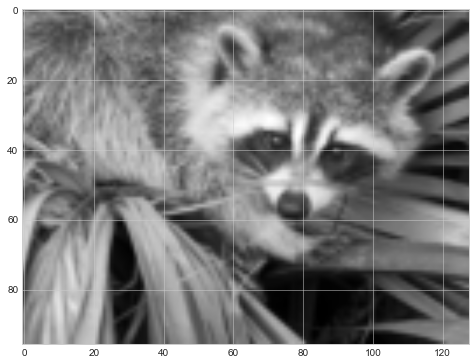

In [297]:
f = misc.face() # Get racoon face from scipy.misc!
f = rgb2gray(f) # Convert to black and white (let's not do multidimensional output GP...)
newsize = tuple([x/8 for x in f.shape]) # must rescale because raw image is too large
f = misc.imresize(f, newsize, interp='bilinear', mode=None)
print 'Sizes:', f.shape, f.size
plt.figure(figsize=(8, 8))
plt.imshow(f, cmap=plt.cm.gist_gray)
plt.show()

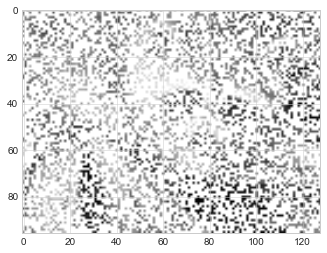

In [298]:
# Let's create a mask, keep some fraction of the pixels
mask_flat = np.zeros(f.size, dtype=bool)
ind_flat = np.random.choice(f.size, int(f.size*0.3), replace=False)
mask_flat[ind_flat] = True
xv, yv = np.meshgrid(np.arange(f.shape[1]), np.arange(f.shape[0]))
Xfull = np.vstack((xv.ravel(), yv.ravel())).T
f_flat = 1*f.ravel()
f_flat[~mask_flat] = 255
f_obs = f_flat.reshape(xv.shape)
plt.imshow(f_obs, cmap=plt.cm.gist_gray)

In [299]:
# Let's train a Gaussian Process (i.e. fit the data and optimise the GP parameters)
X = Xfull[ind_flat, :]
Y = f_flat[ind_flat][:, None]
ker = GPy.kern.RBF(2, ARD=False)
m = GPy.models.GPRegression(X, Y, ker)
m.likelihood.variance.fix(1e-4)
#m.kern.variance.fix(100.0)
#m.kern.lengthscale.fix(1.4)
m.optimize('tnc', messages=1, max_f_eval = 100)

In [303]:
# Let's predict the values for the rest of the image, i.e. run the interpolation
f_rec_mean, f_rec_sigma = m.predict(Xfull, full_cov=False, include_likelihood=False)
f_rec_mean = f_rec_mean.reshape(f.shape)
f_rec_sigma = f_rec_sigma.reshape(f.shape)

In [304]:
# Let's also reconstruct the image at higher resolution than the input!
fac = 2
num1, num0 = fac*f.shape[1], fac*f.shape[0]
xvhigh, yvhigh = np.meshgrid(np.linspace(0, f.shape[1], num1), np.linspace(0, f.shape[0], num0))
Xhigh = np.vstack((xvhigh.ravel(), yvhigh.ravel())).T
f_high_mean, f_high_sigma = m.predict(Xhigh, full_cov=False, include_likelihood=False)
f_high_mean = f_high_mean.reshape(xvhigh.shape)
f_high_sigma = f_high_sigma.reshape(xvhigh.shape)

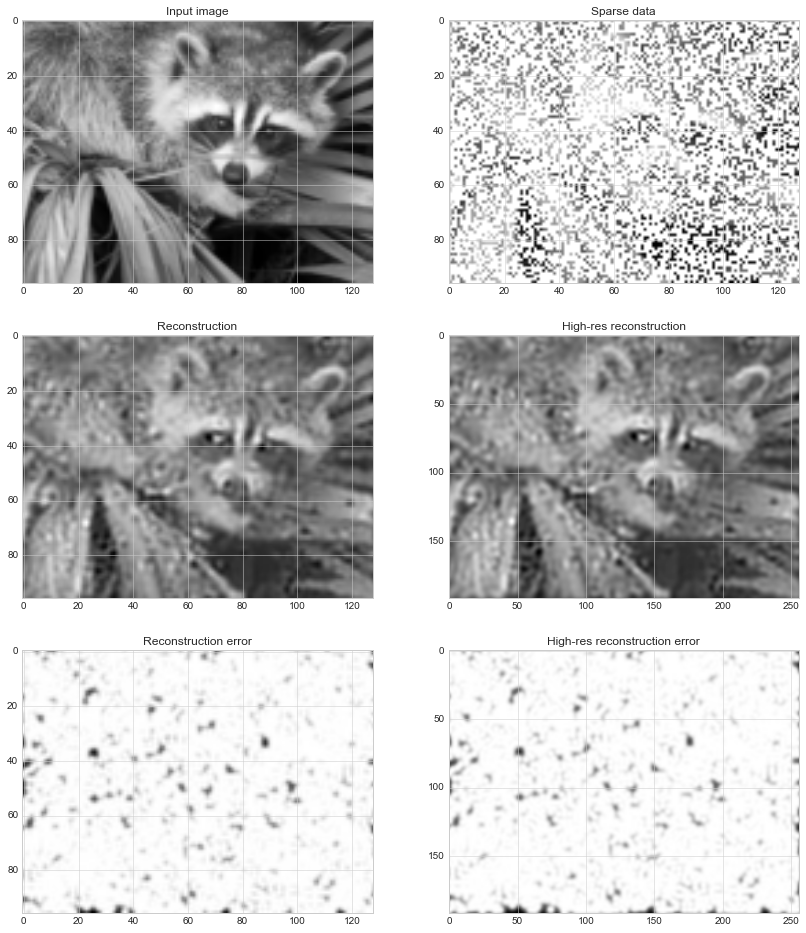

In [311]:
# Plot the results
fig, axs = plt.subplots(3, 2, figsize=(14, 16))
axs = axs.ravel()
axs[0].set_title('Input image')
axs[0].imshow(f, cmap=plt.cm.gist_gray)
axs[1].set_title('Sparse data')
axs[1].imshow(f_obs, cmap=plt.cm.gist_gray)
axs[2].set_title('Reconstruction')
axs[2].imshow(f_rec_mean, cmap=plt.cm.gist_gray)
axs[3].set_title('High-res reconstruction')
axs[3].imshow(f_high_mean, cmap=plt.cm.gist_gray)
axs[4].set_title('Reconstruction error')
axs[4].imshow(f_rec_sigma)
axs[5].set_title('High-res reconstruction error')
axs[5].imshow(f_high_sigma)